# Linear Regression - Biase Variance Trade Off


These are the most common ways to prevent overfitting in neural networks:

* Get more training data.
- Reduce the capacity of the network.
        - No of learnable parameters in a model is often referred to as the model's "capacity".
        - Deep network means more mean more memory which means overfitting. Find the right size DNN
* Add weight regularization.
* Add dropout.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [27]:
df = pd.read_csv('D:\\Sandbox\\Github\\DATA\\kc_house_data.csv')

### Feature Engineering from Date

In [28]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].apply(lambda date:date.month)
df['year'] = df['date'].apply(lambda date:date.year)

In [30]:
df = df.drop('id',axis=1)
df = df.drop('zipcode',axis=1)
df = df.drop('date',axis=1)

In [31]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'year'],
      dtype='object')

### Scaling and Train Test Split

In [32]:
X = df.drop('price', axis=1)
y = df['price']

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train= scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)



17277

In [37]:
X_train.shape

19

### Helping Functions

In [99]:
N_VALIDATION = X_test.shape[0] # int(1e3)
N_TRAIN = X_train.shape[0] #int(1e4)
BUFFER_SIZE = X_train.shape[0] #int(1e4)
BATCH_SIZE = 128 # 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
FEATURES = X_train.shape[1] # 19

In [100]:
N_VALIDATION

4320

#### Learning Rate

In [101]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                  0.001,
                  decay_steps=STEPS_PER_EPOCH*1000,
                  decay_rate=1,
                  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

#### Call backs

In [110]:
def get_callbacks(name):
  return [
   # tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    #tf.keras.callbacks.TensorBoard(logdir/name),
  ]

#### Model Compile and Fit

In [105]:
from tensorflow.keras.losses import BinaryCrossentropy

def compile_and_fit(model, name, optimizer=None, max_epochs=100):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=BinaryCrossentropy(from_logits=True),
                metrics=[BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                        'accuracy']
               )

  model.summary()

  history = model.fit(
                        x = X_train, y= y_train,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs=max_epochs,
                        validation_data=(X_test,y_test),
                        callbacks=get_callbacks(name),
                        verbose=0)

  return history

### Multiple Models

#### Tiny Model

In [106]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [44]:
size_histories = {}

In [45]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny', max_epochs = 10)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 16)                320       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


#### Small Model

In [46]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [47]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', max_epochs = 10)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                320       
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


#### Medium Model

In [48]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [49]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium",  max_epochs = 10)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                1280      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________


#### Large Model

In [50]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [51]:
size_histories['Large'] = compile_and_fit(large_model, "sizes/large", max_epochs = 10)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               10240     
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 513       
Total params: 798,721
Trainable params: 798,721
Non-trainable params: 0
_________________________________________________________________


In [52]:
size_histories

{'Tiny': <tensorflow.python.keras.callbacks.History at 0x28034d512e0>,
 'Small': <tensorflow.python.keras.callbacks.History at 0x2803b837580>,
 'Medium': <tensorflow.python.keras.callbacks.History at 0x2803ba423a0>,
 'large': <tensorflow.python.keras.callbacks.History at 0x2803e435490>}

<AxesSubplot:>

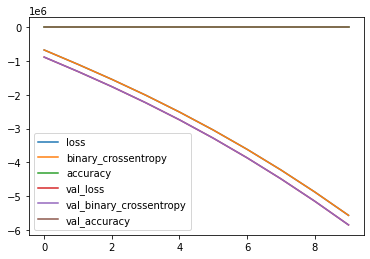

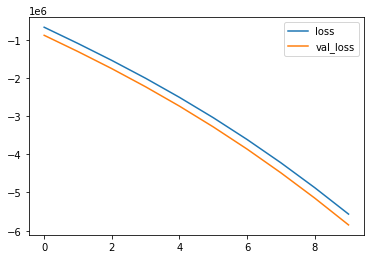

In [90]:
losses = pd.DataFrame(size_histories['Tiny'].history)
losses.plot()
losses[['loss','val_loss']].plot()

<AxesSubplot:>

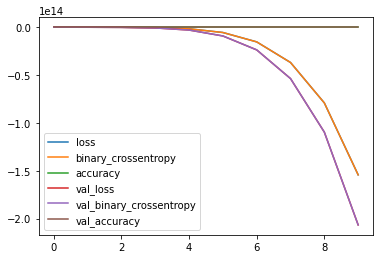

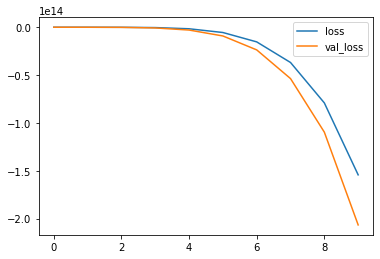

In [94]:
losses = pd.DataFrame(size_histories['Large'].history)
losses.plot()
losses[['loss','val_loss']].plot()

<AxesSubplot:>

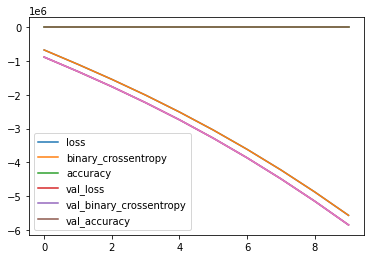

<AxesSubplot:>

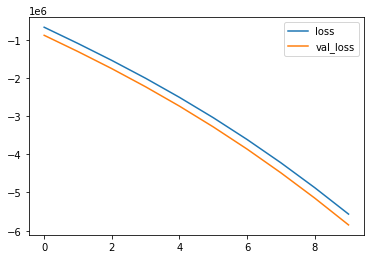

In [89]:
losses[['loss','val_loss']].plot()

### Strategies to prevent overfitting

In [53]:
regularizer_histories = {}

#### Regularization

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: 
Weight decay is mathematically the exact same as L2 regularization.

In [111]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2", max_epochs=10)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 512)               10240     
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_72 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_73 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 513       
Total params: 798,721
Trainable params: 798,721
Non-trainable params: 0
_________________________________________________________________


#### Dropout

In [56]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout", max_epochs=10)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 512)               10240     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)             

In [ ]:
regularizer_historiesv

#### Combining Regularization and Dropout

In [57]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined", max_epochs=10)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 512)               10240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)             

In [58]:
regularizer_histories

{'l2': <tensorflow.python.keras.callbacks.History at 0x2803e74f760>,
 'dropout': <tensorflow.python.keras.callbacks.History at 0x28038bc38b0>,
 'combined': <tensorflow.python.keras.callbacks.History at 0x28041652340>}

<AxesSubplot:>

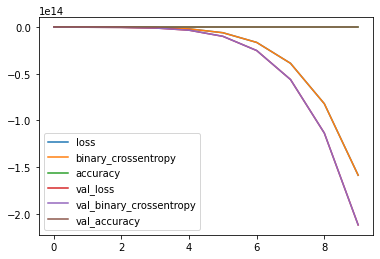

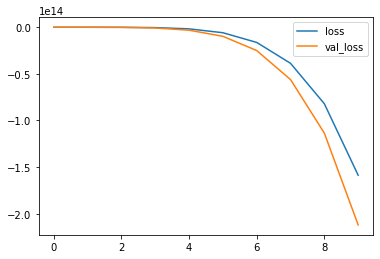

In [96]:
losses = pd.DataFrame(regularizer_histories['l2'].history)
losses.plot()
losses[['loss','val_loss']].plot()